In [1]:
#Suppress Warnings 
import warnings
warnings.filterwarnings('ignore')

#Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn
import keras
import seaborn as sn

#Necessary Imports
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import balanced_accuracy_score

Using TensorFlow backend.


# Nationwide MRM Assessment - J. Barkeloo Ph.D.
## Exploratory Data Analysis
Given is a .csv file of 30,000 simulated people between the ages of 18 and 108 of various education levels (High School/College), an array of incomes, vehicles of 3 types (Standard, Luxury, Truck), and number of accidents over the last two years

## Assessment Assumption: 
All loss events will be categorized as a loss event to make the prediction of loss-like events more straightforward since it is now a binary problem.  This means the few events that have multiple collisions, Order~150 events, will be combined with single accident events.  This is under the assumption that multiple accidents are significantly harder to model and would require much more in depth data about driving history and style than Age, Education, Income, Car Type.

#### Definition of Risk
An extension of this is that any classification into excessively risky individuals is lost.  However, given that the number of multiple loss events (151) is less than 10% of the total amount of loss events (1859) this choice was made to simplify loss estimation.  Without a background in actuarial sciences my best estimation of risk is to find individuals in the 0 loss case events that overlap more closely with those in the loss case.  To do this multiple models are created, a linear logistic model is used in addition to a boosted decision tree model.  In addition to this a quick Random Forest Model was tested as well.  Trying to achieve a high accuracy for loss events even at the expense of falsely classifying no loss events leads to a confusion matrix with columns that can be interpreted as drivers with lower risk (modeled 0 loss drivers, independent of their actual loss) and higher risk (modeled 1 loss drivers).  The falsely categorized no loss drivers who end in the loss category represent higher potential loss while the falsely categorized loss drivers in the no loss category are safer drivers that could be incentivized with discounts or 'accident forgiveness'.  That said the balanced_accuracy has been used to guide model choice while at the same time

In [2]:
mrm_data = pd.read_csv("C:/Users/JTBar/JupyterNotebooks/RM Exercise Files/accident_history.csv")

In [3]:
mrm_data.head()

,Unnamed: 0,age,edu,inc,car,acc
0,1,20,High School,66672.500702,Standard,0
1,2,21,College,71749.949948,Standard,1
2,3,25,College,89297.226073,Standard,0
3,4,18,College,38600.858940,Standard,0
4,5,18,High School,38267.125142,Truck,0


In [4]:
mrm_data.describe()

,Unnamed: 0,age,inc,acc
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,25.033100,80869.337116,0.067900
std,8660.398374,7.598561,24633.663980,0.278374
min,1.000000,18.000000,6897.475627,0.000000
25%,7500.750000,20.000000,63119.116535,0.000000
50%,15000.500000,23.000000,80020.947916,0.000000
75%,22500.250000,28.000000,98102.032547,0.000000
max,30000.000000,108.000000,168742.900640,5.000000


In [5]:
mrm_data.groupby(['edu'])['acc'].count()

edu
College        19646
High School    10354
Name: acc, dtype: int64

In [6]:
mrm_data.groupby(['edu','acc'])['acc'].count()

edu          acc
College      0      18434
             1       1111
             2         87
             3          9
             4          4
             5          1
High School  0       9707
             1        597
             2         44
             3          5
             4          1
Name: acc, dtype: int64

In [7]:
mrm_data.groupby(['car'])['acc'].count()

car
Luxury       3137
Standard    15750
Truck       11113
Name: acc, dtype: int64

In [8]:
mrm_data.groupby(['car','acc'])['acc'].count()

car       acc
Luxury    0       2874
          1        236
          2         23
          3          3
          4          1
Standard  0      14713
          1        940
          2         82
          3         11
          4          3
          5          1
Truck     0      10554
          1        532
          2         26
          4          1
Name: acc, dtype: int64

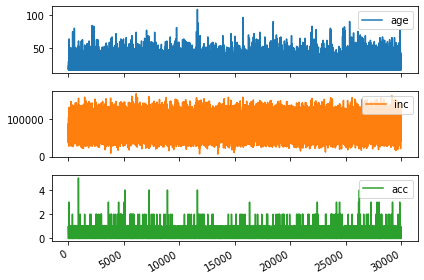

In [9]:
mrm_data.drop(['Unnamed: 0'],axis=1).plot(subplots=True)
plt.tight_layout()
plt.show()

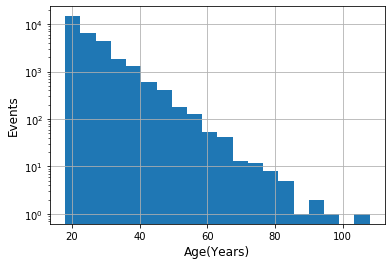

count    30000.000000
mean        25.033100
std          7.598561
min         18.000000
25%         20.000000
50%         23.000000
75%         28.000000
max        108.000000
Name: age, dtype: float64

In [10]:
mrm_data['age'].hist(bins=20)
plt.yscale('log')
plt.xlabel('Age(Years)', fontsize='large')
plt.ylabel('Events', fontsize='large')
plt.show()
mrm_data['age'].describe()

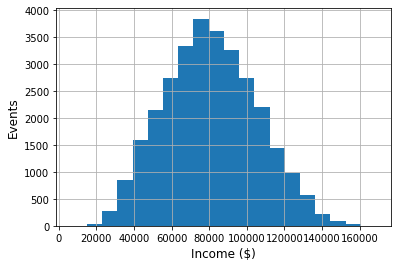

count     30000.000000
mean      80869.337116
std       24633.663980
min        6897.475627
25%       63119.116535
50%       80020.947916
75%       98102.032547
max      168742.900640
Name: inc, dtype: float64

In [11]:
mrm_data['inc'].hist(bins=20)
plt.xlabel('Income ($)', fontsize='large')
plt.ylabel('Events', fontsize='large')
plt.show()
mrm_data['inc'].describe()

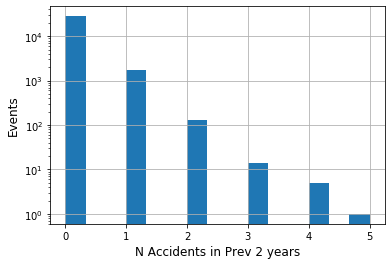

In [12]:
mrm_data['acc'].hist(bins=15)
plt.yscale('log')
plt.xlabel('N Accidents in Prev 2 years', fontsize='large')
plt.ylabel('Events', fontsize='large')
plt.show()

The odd behavior in the above is down to the default binning and scales, it is clear enough what is happening though given the discrete nature of the values.

## Is there a statistically significant difference between vehicle types?
If we assume the loss populations are sampled from a binomial distribution with probability given by TotalLossPerType/TotalType a simple z-test can be conducted to determine if the null hypothesis, the distributions being 'sampled' from a similar distribution, can be rejected.  For a significance $\alpha = 0.05$ a z-value greater than the critical value of 1.64 means the null hypothesis is rejected and the population proportions are statistically significantly different at the 0.05 significance level.  However, there is a nonzero chance that continually looking at distributions will result in a positive effect (The Look-Elsewhere effect) one way to combat this is to divide the significance value youre looking for by the number of unique trials (here 3) and using that critical value.  This then is $\alpha = 0.017$ and chances $z_{critical}=2.40$.  However, the choice of p<0.05 rejecting the null hypothesis is a convention and the distinction here is somewhat arbitrary.  The conclusions that I draw depend on how liberal we want to be in the definition of statistical significance.
\begin{equation*}
z   = \frac{p_1 - p_2}{\sqrt{p (1-p)(1/n_1 + 1/n_2)}}
\end{equation*}

Assumption:  Grouping together all loss events from a single individual into a loss individual and only counting them once 

In [13]:
ProbDict={}
ProbDict['Standard']     = [1037.,15750.];
ProbDict['Luxury'] = [263.,3137.] ;
ProbDict['Truck']   = [559.,11113.];

In [14]:
def calculateZ(ProbDict,Vehicle1,Vehicle2):
    #Takes the total sample size of two distributions and number of 'favorable' cases here the Loss and returns a z-test value
    n1=ProbDict[Vehicle1][1]
    x1=ProbDict[Vehicle1][0]
    n2=ProbDict[Vehicle2][1]
    x2=ProbDict[Vehicle2][0]
    p1 = x1/n1
    p2 = x2/n2
    p  = (x1+x2)/(n1+n2)
    z  = np.abs(p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))
    print('z value for %s and %s: %.2f'%(Vehicle1,Vehicle2,z))
    return z
usedKeys=[]
for key in ProbDict:
    usedKeys.append(key)
    for key2 in ProbDict:
        if key !=key2 and key2 not in usedKeys:
            calculateZ(ProbDict,key,key2)

z value for Standard and Luxury: 3.64
z value for Standard and Truck: 5.31
z value for Luxury and Truck: 7.11


All of these values are above the critical value of 2.4 implying that the null hypothesis can be rejected and the proportions are significantly different.  As such they should be treated separately and are separated out for this reason, presumably. 

What about the education level?

In [15]:
ProbDict={}
ProbDict['High School']     = [647.,10354.];
ProbDict['College'] = [1212.,19646.] ;
calculateZ(ProbDict,'High School','College')


z value for High School and College: 0.27


0.2718594419880757

The z-value for education level implies that the populations could have been sampled from the same distribution and as such should not offer much in terms of separation power.  This makes sense as its also correlated heavily with age

## Categorical Data
### One-hot Encoding
Common issues with categorical variables with a transition into a computational space is that the understanding of the innate difference is lost in the transition or can be taken askew. Here the car type category (Luxury, Standard, Truck) might have different loss functions but transitioning to an integer labeled system (1,2,3) could introduce ranking based on those relative values used for computation within various models.  This is bypassed by using one-hot encoding on these data.  Switching from a string labeled column to 3 boolean columns allows the model to know if the event is in each type with the boolean value allows the weight to only impact the correct class. 
A similar encoding can be done with the education level variable.  With only 'High School' and 'College' entries this could be classified with a singular column.  For transparent models (i.e., where variable weights arent correlated with hidden variables like in a neural network) this simplifies the literal interpretation of the model variables.  In more opaque models this process still prevents ranking bias on the input parameters.

In [16]:
one_hot_car=pd.get_dummies(mrm_data.car,prefix='car')
one_hot_edu=pd.get_dummies(mrm_data.edu,prefix='edu')

In [17]:
tmp_data=pd.concat([mrm_data,one_hot_edu],axis=1)
tmp_data =tmp_data.drop(['edu'],axis=1)
tmp_data=pd.concat([tmp_data,one_hot_car],axis=1)
tmp_data =tmp_data.drop(['Unnamed: 0','car'],axis=1)
mrm2 =tmp_data
mrm2.head()

,age,inc,acc,edu_College,edu_High School,car_Luxury,car_Standard,car_Truck
0,20,66672.500702,0,0,1,0,1,0
1,21,71749.949948,1,1,0,0,1,0
2,25,89297.226073,0,1,0,0,1,0
3,18,38600.858940,0,1,0,0,1,0
4,18,38267.125142,0,0,1,0,0,1


Correlation Matrix For Non-Categorical Variables

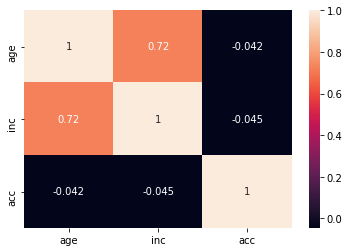

In [18]:
corrMatrix = mrm_data.drop(columns=['Unnamed: 0']).corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [19]:
mrm_data.drop(columns=['Unnamed: 0']).describe()

,age,inc,acc
count,30000.000000,30000.000000,30000.000000
mean,25.033100,80869.337116,0.067900
std,7.598561,24633.663980,0.278374
min,18.000000,6897.475627,0.000000
25%,20.000000,63119.116535,0.000000
50%,23.000000,80020.947916,0.000000
75%,28.000000,98102.032547,0.000000
max,108.000000,168742.900640,5.000000


#### Counts for various subsets of variables i.e., number of each type of vehicle, number of accidents per person, college/High School breakdown


In [20]:
mrm_data['car'].value_counts()

Standard    15750
Truck       11113
Luxury       3137
Name: car, dtype: int64

In [21]:
mrm_data['acc'].value_counts()

0    28141
1     1708
2      131
3       14
4        5
5        1
Name: acc, dtype: int64

In [22]:
mrm_data['edu'].value_counts()

College        19646
High School    10354
Name: edu, dtype: int64

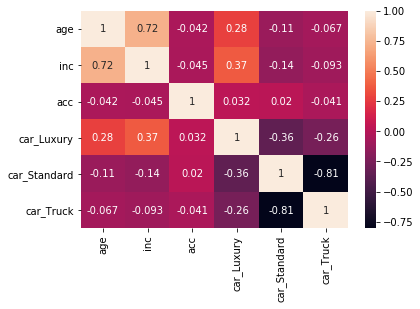

In [23]:
corrMatrix = mrm2.drop(['edu_High School','edu_College'],axis=1).corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

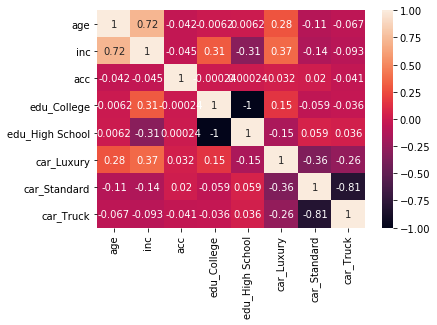

In [43]:
corrMatrix = mrm2.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### Plot of Age vs. Income for individuals with loss events and no loss events in their history

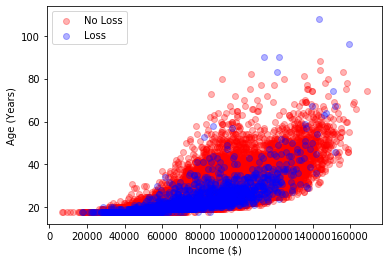

In [24]:
plt.scatter(mrm2['inc'][mrm2['acc']==0],mrm2['age'][mrm2['acc']==0],color='red',alpha=0.3,label= "No Loss")
plt.scatter(mrm2['inc'][mrm2['acc']>0],mrm2['age'][mrm2['acc']>0],color='blue',alpha=0.3, label= "Loss")
plt.xlabel('Income ($)')
plt.ylabel('Age (Years)')
plt.legend()

## Single Variable Logistic Regression
As Age and Income are highly correlated with each other it makes sense to attempt a straight forward single variable regression for event classification first.  Income has the slightly stronger correlation with Accidents so that will be the variable of interest.

In [25]:
X = mrm2[['inc']]
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)
y.value_counts()

logreg = LogisticRegression()
scaler = RobustScaler()
X=scaler.fit_transform(X)

# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#np.bincount(y_train)
#logreg.fit(X_train,y_train)
yhat = logreg.predict(X_test)
yhat.sum()
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
print('Balanced Accuracy Score: {:.3f}'.format(balanced_accuracy_score(y_test,y_pred)))

Accuracy of logistic regression classifier on test set: 0.942
Balanced Accuracy Score: 0.500


### Trying single variable with SMOTE Resampling

In [26]:
# Import 'LogisticRegression' and create a LogisticRegression object
logreg = LogisticRegression()
X = mrm2[['inc']]
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)

scaler = RobustScaler()
X=scaler.fit_transform(X)

# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_smote, y_train_smote)
y_pred = logreg.predict(X_test)
yhat = logreg.predict(X_test)
yhat.sum()
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
print("Balanced Accuracy Score: {:.3f}".format(balanced_accuracy_score(y_test,y_pred)))

Accuracy of logistic regression classifier on test set: 0.523
Balanced Accuracy Score: 0.529


## Multivariate Logistic Regression
As can be seen there are significantly fewer events with 1 or more accidents.  This unbalanced data is expected due to the nature of the situation and is typical for models within many industries.  (28141 No loss events, 1859 Loss events)

In [27]:
X = mrm2[['age', 'inc', 'car_Luxury','car_Standard']]#, 'car_Truck']] #'edu_High School', 'edu_College',
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)
y.value_counts()

logreg = LogisticRegression()
scaler = RobustScaler()
X=scaler.fit_transform(X)

# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#np.bincount(y_train)
#logreg.fit(X_train,y_train)
yhat = logreg.predict(X_test)
yhat.sum()
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
print('Balanced Accuracy Score: {:.3f}'.format(balanced_accuracy_score(y_test,y_pred)))

Accuracy of logistic regression classifier on test set: 0.942
Balanced Accuracy Score: 0.500


A straight unweighted default sampling of the events leads to an accuracy equal to the class distribution where everything is called one class (the majority class).  This is seen in the accuracy being the distribution values and the balanced accuracy being 0.5 (100% correct majority, 100% incorrect minority)

### Resampling the minority class using SMOTE
Synthetic Minority Oversampling TEchnique (SMOTE) generates synthetic data that is similar to, but not exactly like the minority class using nearest-neightbors approach to fill in space between neighbors.  This is done by selecting k-nearest neighbors (typically k=5), chosing a random neighbor and drawing a line through the feature space and a new synthetic point is selected between the two chosen points.

A downside to smote as opposed to other oversampling techniques such as ADASYN is that SMOTE creates more realistic points without weighing phase space boundary points (i.e. harder to train points) or any consideration of the minority class phase space with respect to the phase spaces of the majority class.

In [28]:
# Import 'LogisticRegression' and create a LogisticRegression object
logreg = LogisticRegression()
X = mrm2[['age', 'inc', 'edu_High School', 'car_Luxury','car_Standard', 'car_Truck']] #'edu_High School', 'edu_College',
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)

scaler = RobustScaler()
X=scaler.fit_transform(X)
# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_smote, y_train_smote)
y_pred = logreg.predict(X_test)
#np.bincount(y_train)
#logreg.fit(X_train,y_train)
yhat = logreg.predict(X_test)
yhat.sum()
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
print("Balanced Accuracy Score: {:.3f}".format(balanced_accuracy_score(y_test,y_pred)))
print("Coefficients: ",logreg.coef_)

Accuracy of logistic regression classifier on test set: 0.535
Balanced Accuracy Score: 0.551
Coefficients:  [[-0.0853679  -0.42247345 -0.02247482  0.59881271 -0.19164023 -0.40717248]]


[[3014 2638]
 [ 150  198]]


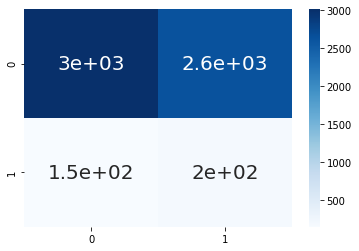

In [29]:
# Confusion Matrix of:
#                     True Negative,  False Positive
#                     False Negative, True Positive
# for model prediction outputs of the test sample
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sn.heatmap(conf_matrix, annot=True,annot_kws={"size": 20}, cmap='Blues')
tn, fp, fn, tp = conf_matrix.ravel()

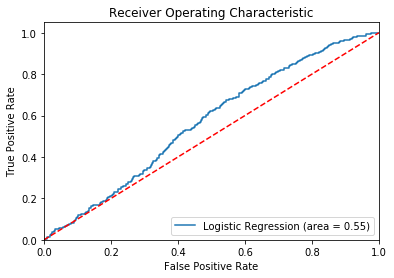

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Statsmodels logit regressor

Optimization terminated successfully.
         Current function value: 0.447322
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    acc   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23996
Method:                           MLE   Df Model:                            3
Date:                Sun, 15 Nov 2020   Pseudo R-squ.:                 -0.9032
Time:                        10:30:28   Log-Likelihood:                -10736.
converged:                       True   LL-Null:                       -5640.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0170      0.035    -28.741      0.000      -1.086      -0.948
x2             0.9411      0.

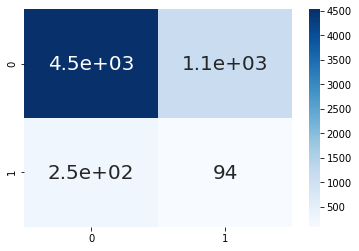

In [31]:
import statsmodels.api as sm
X = mrm2[['age', 'inc', 'car_Luxury','car_Standard', 'car_Truck']] #'edu_High School', 'edu_College',
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)
#exog, endog = sm.add_constant(X), y
#model = sm.GLM(endog, exog,
#             family=sm.families.Binomial())
#res = model.fit()
scaler = RobustScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
logreg = sm.Logit(y_train,X_train).fit()
print(logreg.summary())

##Confusion Matrix
yhat = logreg.predict(X_test) 
y_pred = list(map(round, yhat)) 
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sn.heatmap(conf_matrix, annot=True,annot_kws={"size": 20}, cmap='Blues')
tn, fp, fn, tp = conf_matrix.ravel()
print("Balanced Accuracy Score: {:.3f}".format(balanced_accuracy_score(y_test,y_pred)))

## Random Forest Classifier
A Random Forest should be able to work well out of the box with unbalanced majority/minority data sets.  The balanced accuracy is reported which is defined as the average of recall obtained on each class.

Balanced Accuracy Score:  0.4998648449909492
ROC AUC Score:  0.5222632370586787


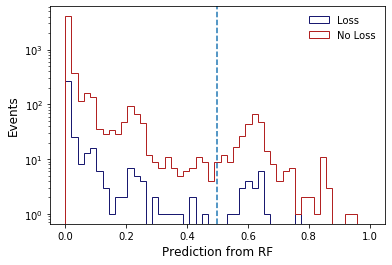

In [32]:
from sklearn.ensemble import RandomForestClassifier
X = mrm2[['age', 'inc', 'car_Luxury','car_Standard']]#'edu_High School', 'edu_College',
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)
scaler = RobustScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rfc = RandomForestClassifier(n_estimators=1000,random_state=0, class_weight='balanced')
rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)
print("Balanced Accuracy Score: ", balanced_accuracy_score(y_test,pred))
prob = rfc.predict_proba(X_test)
prob = [p[1] for p in prob]
print ("ROC AUC Score: ",roc_auc_score(y_test,prob))

plt.figure();
plt.hist(rfc.predict_proba(X_test[y_test==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(rfc.predict_proba(X_test[y_test==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from RF',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.yscale('log')
plt.axvline(x=0.5, linestyle='--')
plt.legend(frameon=False);

## BDT Model with SMOTE Resampling of Minority Class

In [33]:
X = mrm2[['age', 'inc', 'car_Luxury','car_Standard', 'car_Truck']] #'edu_High School', 'edu_College',
y = mrm2['acc']
y = y.astype('bool').astype('int') #easy conversion of (0,nonzero) to (0,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)
features = X_train.columns

In [34]:
print('Number of training samples: {}'.format(len(X_train)))
print('Number of testing samples: {}'.format(len(X_test)))
print('SMOTE: Number of training samples: {}'.format(len(X_train_smote)))

print('\nNumber of signal events in training set: {}'.format(len(y_train[y_train == 1])))
print('SMOTE:Number of signal events in training set: {}'.format(len(y_train_smote[y_train_smote == 1])))
print('Number of background events in training set: {}'.format(len(y_train[y_train == 0])))
print('Fraction signal: {:.3f}'.format(len(y_train[y_train == 1])/(float)(len(y_train[y_train == 1]) + len(y_train[y_train == 0]))))
print('SMOTE: Fraction signal: {:.2f}'.format(len(y_train_smote[y_train_smote == 1])/(float)(len(y_train_smote[y_train_smote == 1]) + len(y_train_smote[y_train_smote == 0]))))

Number of training samples: 24000
Number of testing samples: 6000
SMOTE: Number of training samples: 45028

Number of signal events in training set: 1486
SMOTE:Number of signal events in training set: 22514
Number of background events in training set: 22514
Fraction signal: 0.062
SMOTE: Fraction signal: 0.50


In [35]:
binary_bdt_param = {
    "learning_rate" : 0.15,
    "max_depth" :6,
    "colsample_bytree" : 1.0,
    "subsample" : 1.0,
    "n_estimators" : 200,
    "feature_names" : features,
    'objective' : 'binary:logistic' # objective function
}
binary_task_param = {
    "eval_metric" : ["logloss","error"],
    "early_stopping_rounds" : 30,
    "eval_set": [(X_train_smote[features],y_train_smote), 
                 (X_test[features],y_test)]
}

binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train_smote[features], y_train_smote,
              verbose=False, **binary_task_param)

[10:30:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=Index(['age', 'inc', 'car_Luxury', 'car_Standard', 'car_Truck'], dtype='object'),
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [36]:
evaluated_df = X_test.copy()
evaluated_df["binary_prob"] = binary_bdt.predict_proba(X_test[features])[:,1]
print(binary_bdt.score(X_test[features],y_test))

binary_bdt.predict_proba(X_test[features])[:,1].round().sum()

0.867


491.0

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

predictions = binary_bdt.predict(X_test[features])
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(binary_bdt.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(binary_bdt, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_smote[features])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_smote)
    # eval model
    select_X_test = selection.transform(X_test[features])
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test,predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Loss Event Accuracy: %.2f%%"%(predictions[y_test==1].sum()/y_test.sum()*100.))
    print("Balanced Accuracy: %.2f%%"%(bal_acc*100.))

Accuracy: 86.70%
Thresh=0.008, n=5, Accuracy: 84.33%
Loss Event Accuracy: 11.80%
Balanced Accuracy: 50.47%
Thresh=0.009, n=4, Accuracy: 82.77%
Loss Event Accuracy: 13.40%
Balanced Accuracy: 50.38%
Thresh=0.298, n=3, Accuracy: 93.78%
Loss Event Accuracy: 0.00%
Balanced Accuracy: 50.00%
Thresh=0.337, n=2, Accuracy: 61.27%
Loss Event Accuracy: 26.54%
Balanced Accuracy: 45.06%
Thresh=0.348, n=1, Accuracy: 15.30%
Loss Event Accuracy: 85.52%
Balanced Accuracy: 48.08%


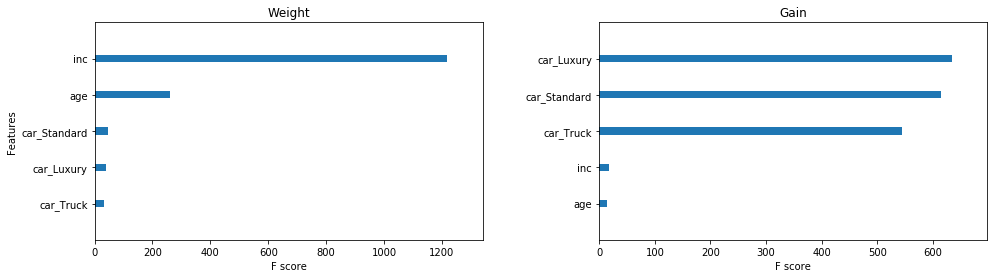

In [38]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
xgb.plot_importance(binary_bdt, importance_type="weight", ax=ax_enum[0], title="Weight",show_values=False, grid=False)
xgb.plot_importance(binary_bdt, importance_type="gain", ax=ax_enum[1], title="Gain", show_values=False, grid=False)
plt.ylabel("")
plt.sca(ax_enum[1])
plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

importance_type=Weight is how frequently splitting on the variable occurs where importance_type=Gain is how useful is the variable in terms of separation 

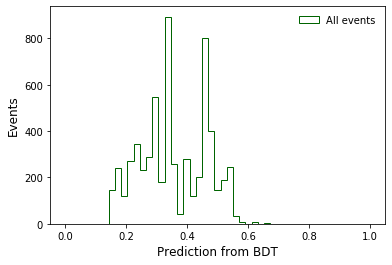

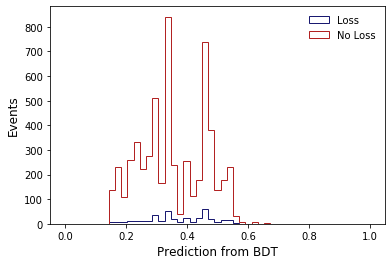

In [39]:
# plot all predictions (both signal and background)
predictions = binary_bdt.predict_proba(X_test[features])[:,1]
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

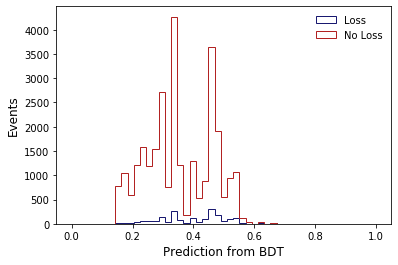

In [40]:
plt.figure();
plt.hist(binary_bdt.predict_proba(X[features][y==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X[features][y==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

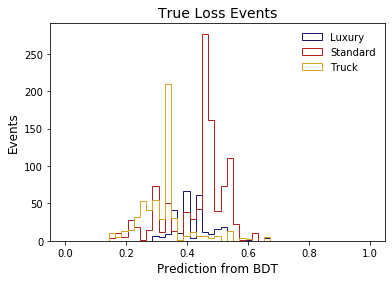

In [41]:
plt.figure();
plt.hist(binary_bdt.predict_proba(X[features][X['car_Luxury']==1][y==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Luxury');
plt.hist(binary_bdt.predict_proba(X[features][X['car_Standard']==1][y==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Standard');
plt.hist(binary_bdt.predict_proba(X[features][X['car_Truck']==1][y==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='goldenrod',label='Truck');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.title('True Loss Events',fontsize=14)
plt.legend(frameon=False);

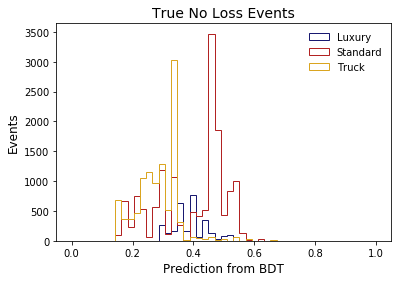

In [42]:
plt.figure();
plt.hist(binary_bdt.predict_proba(X[features][X['car_Luxury']==1][y==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Luxury');
plt.hist(binary_bdt.predict_proba(X[features][X['car_Standard']==1][y==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Standard');
plt.hist(binary_bdt.predict_proba(X[features][X['car_Truck']==1][y==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='goldenrod',label='Truck');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.title('True No Loss Events',fontsize=14)
plt.legend(frameon=False);